In [1]:
from unittest.mock import inplace

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from keras.src.callbacks import EarlyStopping
import random
import numpy as np
import tensorflow as tf
from keras.api.layers import Dense, Dropout
from keras.api.models import Sequential
from keras.api.regularizers import l1, l2
from keras.api.optimizers import Adam

In [2]:
def set_seeds(seed = 100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
def cw(df):
    c0, c1 = np.bincount(df["dir"])
    w0 = (1/c0) * (len(df)) / 2
    w1 = (1/c1) * (len(df)) / 2
    return {0:w0, 1:w1}

In [3]:
symbol = "EURUSD=X"
#start = "2022-08-27"
start = "2022-08-28"
end = "2024-08-22"
interval = '1h'
ptc = 0.000059
lags = 7

In [4]:
df = yf.download(symbol, start, end, interval=interval)
#df.rename(columns={"Close": "price"}, inplace=True)
df.drop(columns=['Adj Close', 'Volume'], inplace=True)
#df.index = df.index.tz_convert('utc')
df['returns'] = np.log(df['Close'].div(df['Close'].shift(1)))
df['day_of_week'] = df.index.dayofweek
df['dir'] = np.where(df['returns'] > 0, 1,0)
df.dropna(inplace=True)
features = ['Open', 'High', 'Low', 'Close', 'returns']

[*********************100%%**********************]  1 of 1 completed


In [5]:
copy = df.copy()
cols = []
for f in features:
    for lag in range(1, lags + 1):
        col = "{}_lag_{}".format(f, lag)
        copy[col] = copy[f].shift(lag)
        cols.append(col)
copy.dropna(inplace=True)
cols.append('day_of_week')
split = int(len(copy)* 0.8)
train = copy.iloc[:split].copy()
test = copy.iloc[split:].copy()
mu, std = train.mean(), train.std()
train_standardized = (train-mu) / std

In [6]:
### Parameters
dropout = 0.3

In [7]:
optimizer = Adam(learning_rate = 0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

set_seeds(100)
model = Sequential()
model.add(Dense(32, input_dim = len(cols), activity_regularizer = None ,activation = "relu", kernel_regularizer=l2(0.001), )) 
model.add(Dropout(dropout, seed = 100))
model.add(Dense(32, activation = "relu", activity_regularizer = None, kernel_regularizer=l2(0.001),))
model.add(Dense(32, activation = "relu", activity_regularizer = None, kernel_regularizer=l2(0.001),))    
model.add(Dropout(dropout, seed = 100))        
model.add(Dense(1, activation = "sigmoid")) 
model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])

model.fit(x=train_standardized[cols], y=train['dir'], epochs=30, verbose=False,
          validation_split=0.2, shuffle=False, class_weight=cw(train), callbacks=[early_stopping] )


C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\trainers\data_adapters\data_adapter_utils.py:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_weight[i] = class_weight.get(int(y[i]), 1.0)


In [8]:
loss_train, accuracy_train =  model.evaluate(train_standardized[cols], train['dir'])
predict = model.predict(train_standardized[cols])

test_standardized = (test-mu) / std
loss_test, accuracy_test =  model.evaluate(test_standardized[cols], test['dir'])
test['probability'] = model.predict(test_standardized[cols])
threshold = 0.53
test['position'] = np.where(test.probability < (1-threshold), -1, np.nan)
test['position'] = np.where(test.probability > threshold, 1, test.position)
test['position'] = test.position.ffill()
test['strategy'] = test['position'] * test['returns']
test['creturns'] = test['returns'].cumsum().apply(np.exp)
test['cstrategy'] = test['strategy'].cumsum().apply(np.exp)
test['trades'] = test.position.diff().abs()
test['strategy_net'] = test.strategy - test.trades * ptc
test['cstrategy_net'] = test['strategy_net'].cumsum().apply(np.exp)

308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - accuracy: 0.5104 - loss: 0.7338
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - accuracy: 0.5346 - loss: 0.7346
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step


In [9]:
print(f"Loss: {loss_train}")
print(f"Accuracy: {accuracy_train}")

Loss: 0.7336093187332153
Accuracy: 0.5286397337913513


In [10]:
print(f"Loss: {loss_test}")
print(f"Accuracy: {accuracy_test}")

Loss: 0.7342873811721802
Accuracy: 0.5423108339309692


<Axes: >

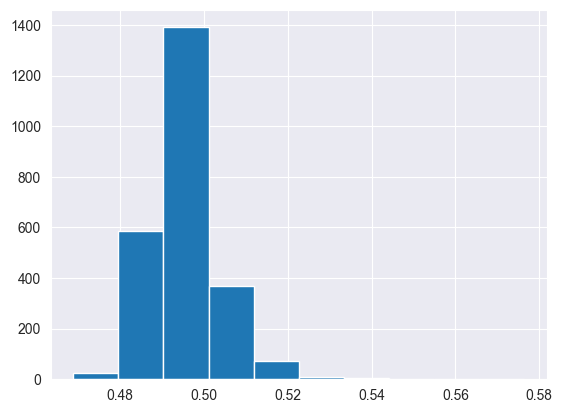

In [11]:
test.probability.hist()

In [12]:
test.creturns.corr(test.cstrategy)

0.9999245998700397

In [13]:
test.position.value_counts()

position
 1.0    2264
-1.0       7
Name: count, dtype: int64

308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step


<Axes: xlabel='Datetime'>

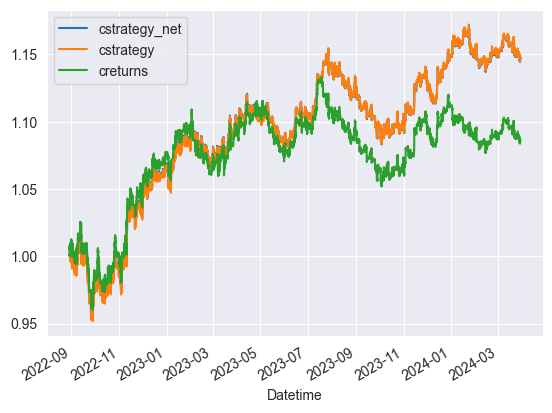

In [14]:
train['probability'] = model.predict(train_standardized[cols])
threshold = 0.53
train['position'] = np.where(train.probability < (1-threshold), -1, np.nan)
train['position'] = np.where(train.probability > threshold, 1, train.position)
train['position'] = train.position.ffill()
train['strategy'] = train['position'] * train['returns']
train['creturns'] = train['returns'].cumsum().apply(np.exp)
train['cstrategy'] = train['strategy'].cumsum().apply(np.exp)
train['trades'] = train.position.diff().abs()
train['strategy_net'] = train.strategy - train.trades * ptc
train['cstrategy_net'] = train['strategy_net'].cumsum().apply(np.exp)
train[['cstrategy_net', 'cstrategy', 'creturns']].plot()

<Axes: xlabel='Datetime'>

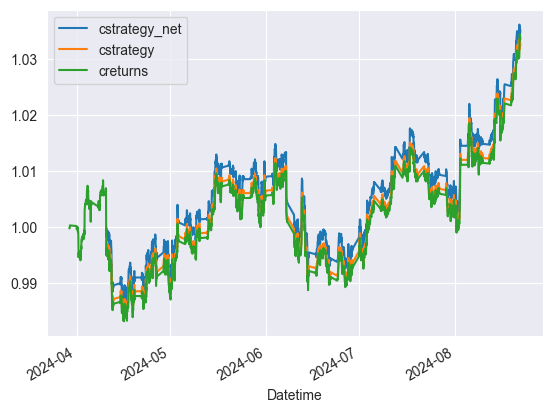

In [15]:
test[['cstrategy_net', 'cstrategy', 'creturns']].plot()

In [16]:
analysis = test.copy()
analysis.drop(columns = cols, inplace = True)
analysis.dropna(inplace = True)

In [17]:
analysis.cstrategy_net.iloc[-1]

1.0347199729198437

In [18]:
analysis

,Open,High,Low,Close,returns,dir,probability,position,strategy,creturns,cstrategy,trades,strategy_net,cstrategy_net
Datetime,,,,,,,,,,,,,,
2024-04-10 15:00:00+01:00,1.075384,1.076890,1.075038,1.075616,-0.000108,0,0.527297,1.0,-0.000108,0.996558,0.997418,0.0,-0.000108,0.999892
2024-04-10 16:00:00+01:00,1.075732,1.075732,1.073768,1.073883,-0.001612,0,0.504584,1.0,-0.001612,0.994953,0.995812,0.0,-0.001612,0.998282
2024-04-10 17:00:00+01:00,1.073998,1.073998,1.073192,1.073883,0.000000,0,0.512319,1.0,0.000000,0.994953,0.995812,0.0,0.000000,0.998282
2024-04-10 18:00:00+01:00,1.073883,1.075500,1.073192,1.075269,0.001290,1,0.501237,1.0,0.001290,0.996237,0.997097,0.0,0.001290,0.999570
2024-04-10 19:00:00+01:00,1.075384,1.075616,1.073883,1.073883,-0.001290,0,0.509258,1.0,-0.001290,0.994953,0.995812,0.0,-0.001290,0.998282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-21 19:00:00+01:00,1.116321,1.117693,1.116321,1.116445,0.000447,1,0.475612,-1.0,-0.000447,1.034387,1.031821,0.0,-0.000447,1.034258
2024-08-21 20:00:00+01:00,1.116321,1.116321,1.115449,1.115573,-0.000781,0,0.481678,-1.0,0.000781,1.033579,1.032627,0.0,0.000781,1.035066
2024-08-21 21:00:00+01:00,1.115573,1.115822,1.115076,1.115324,-0.000223,0,0.495468,-1.0,0.000223,1.033348,1.032858,0.0,0.000223,1.035297


In [19]:
analysis['dir_position'] = np.where(analysis['probability'] < 0.47, 0, np.where(analysis['probability'] > 0.53, 1, np.nan))

In [20]:
analysis[(analysis.dir_position != analysis.dir) & (pd.notna(analysis.dir_position))]

,Open,High,Low,Close,returns,dir,probability,position,strategy,creturns,cstrategy,trades,strategy_net,cstrategy_net,dir_position
Datetime,,,,,,,,,,,,,,,
2024-04-23 13:00:00+01:00,1.067692,1.067806,1.066667,1.067350,-0.000320,0,0.544381,1.0,-0.000320,0.988900,0.989753,0.0,-0.000320,0.992208,1.0
2024-05-02 00:00:00+01:00,1.071926,1.072156,1.071582,1.072041,0.000000,0,0.576389,1.0,0.000000,0.993246,0.994104,0.0,0.000000,0.996569,1.0
2024-06-07 17:00:00+01:00,1.081081,1.081432,1.080614,1.080847,-0.000108,0,0.540488,1.0,-0.000108,1.001405,1.002270,0.0,-0.000108,1.004756,1.0
2024-06-12 18:00:00+01:00,1.084599,1.084834,1.084011,1.084128,-0.000542,0,0.555139,1.0,-0.000542,1.004445,1.005312,0.0,-0.000542,1.007806,1.0
2024-08-02 18:00:00+01:00,1.091584,1.091703,1.091107,1.091346,-0.000109,0,0.540141,1.0,-0.000109,1.011132,1.012005,0.0,-0.000109,1.014515,1.0
2024-08-21 17:00:00+01:00,1.114579,1.115200,1.114579,1.114951,0.000334,1,0.468801,-1.0,-0.000334,1.033003,1.033203,2.0,-0.000452,1.035644,0.0


In [21]:
analysis[(analysis.dir_position != analysis.dir) & (pd.notna(analysis.dir_position))].probability.describe()

count    6.000000
mean     0.537556
std      0.036349
min      0.468801
25%      0.540228
50%      0.542434
75%      0.552450
max      0.576389
Name: probability, dtype: float64

In [22]:
analysis[analysis.dir_position == analysis.dir]

,Open,High,Low,Close,returns,dir,probability,position,strategy,creturns,cstrategy,trades,strategy_net,cstrategy_net,dir_position
Datetime,,,,,,,,,,,,,,,
2024-05-03 18:00:00+01:00,1.076774,1.077122,1.076195,1.077006,0.000323,1,0.542091,1.0,0.000323,0.997846,0.998708,0.0,0.000323,1.001185,1.0
2024-05-15 18:00:00+01:00,1.087548,1.088258,1.087548,1.088258,0.000653,1,0.546979,1.0,0.000653,1.008271,1.009141,0.0,0.000653,1.011644,1.0
2024-08-05 13:00:00+01:00,1.096491,1.100958,1.096491,1.099384,0.002525,1,0.541049,1.0,0.002525,1.018580,1.019459,0.0,0.002525,1.021988,1.0


In [23]:
analysis[analysis.dir_position == analysis.dir].probability.describe()

count    3.000000
mean     0.543373
std      0.003166
min      0.541049
25%      0.541570
50%      0.542091
75%      0.544535
max      0.546979
Name: probability, dtype: float64